##**SETUP**

In [ ]:
import datetime
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class Inode:
    def __init__(self, id, is_dir=False, nome=""):
        self.id = id
        self.is_dir = is_dir
        self.nome = nome
        self.tamanho = 0
        self.timestamp = datetime.datetime.now()
        # I-NODE SE ASSOCIA AOS BLOCOS DE DADOS.
        # funciona como um "mapa" ou "índice" para os dados.
        self.ponteiros_blocos = []

class BlocoEncadeado:
    def __init__(self, dados, proximo_bloco=-1):
        self.dados = dados
        self.proximo_bloco = proximo_bloco # -1 indica o fim do arquivo

class SistemaArquivosInode:
    def __init__(self):
        # Os i-nodes são criados junto com o sistema de arquivos, pré-alocados.
        self.MAX_INODES = 20
        self.MAX_BLOCOS = 100 # Disco com 100 blocos
        self.TAMANHO_BLOCO = 10 # Bytes por bloco

        # O TIPO DE DADOS DO BLOCO: Uma lista Python, onde cada índice é um endereço.
        self.blocos_dados = [None] * self.MAX_BLOCOS

        # GERENCIAMENTO DE I-NODES E BLOCOS LIVRES: Usamos "mapas de bits".
        # Uma lista de booleanos. 'False' significa livre, 'True' significa ocupado.
        self.tabela_inodes = [None] * self.MAX_INODES # A lista de i-nodes
        self.mapa_bits_inodes = [False] * self.MAX_INODES # Lista de i-nodes livres
        self.mapa_bits_blocos = [False] * self.MAX_BLOCOS # Lista de blocos livres

        # Inicializa o diretório raiz "/"
        self.diretorio_raiz = self._criar_inode(is_dir=True, nome="/")
        self.diretorio_atual_inode_id = self.diretorio_raiz.id
        self._adicionar_entrada_diretorio(self.diretorio_raiz, ".", self.diretorio_raiz.id)
        self._adicionar_entrada_diretorio(self.diretorio_raiz, "..", self.diretorio_raiz.id)

    def _alocar_inode(self):
        for i, u in enumerate(self.mapa_bits_inodes):
            if not u: self.mapa_bits_inodes[i] = True; return i
        return None

    def _alocar_bloco(self):
        """
        COMO OS BLOCOS SÃO ESCOLHIDOS: A estratégia é sequencial.
        Percorremos o mapa de bits e pegamos o PRIMEIRO bloco livre que encontrarmos.
        Não é aleatório.
        """
        for i, u in enumerate(self.mapa_bits_blocos):
            if not u: self.mapa_bits_blocos[i] = True; return i
        return None

    # O resto das funções (mkdir, touch, etc.) foram instrumentadas para retornar
    # o número de "operações de disco" que realizaram.
    def _criar_inode(self, is_dir=False, nome=""):
        inode_id = self._alocar_inode()
        if inode_id is None: raise Exception("Erro: Sem i-nodes livres.")
        self.tabela_inodes[inode_id] = Inode(inode_id, is_dir, nome)
        return self.tabela_inodes[inode_id]
    def _get_entradas_diretorio(self, inode_dir):
        return [e for id_b in inode_dir.ponteiros_blocos if self.blocos_dados[id_b] for e in self.blocos_dados[id_b]]
    def _adicionar_entrada_diretorio(self, inode_dir, nome, inode_id_alvo):
        if not inode_dir.ponteiros_blocos:
            id_novo_bloco = self._alocar_bloco()
            if id_novo_bloco is None: raise Exception("Erro: Sem blocos de dados livres.")
            inode_dir.ponteiros_blocos.append(id_novo_bloco)
            self.blocos_dados[id_novo_bloco] = []
        self.blocos_dados[inode_dir.ponteiros_blocos[-1]].append({'nome': nome, 'inode_id': inode_id_alvo})
    def _encontrar_inode_por_nome(self, nome, inode_dir_id):
        for entrada in self._get_entradas_diretorio(self.tabela_inodes[inode_dir_id]):
            if entrada['nome'] == nome: return entrada['inode_id']
        return None
    def _resolver_caminho_para_alvo_e_pai(self, caminho):
        if not caminho.startswith('/'): print(f"Erro: Caminho '{caminho}' deve ser absoluto."); return None, None, None
        partes = [p for p in caminho.split('/') if p]
        if not partes: return self.diretorio_raiz, None, "/"
        nome_alvo, caminho_pai_partes, id_pai = partes[-1], partes[:-1], self.diretorio_raiz.id
        for parte in caminho_pai_partes:
            id_proximo_pai = self._encontrar_inode_por_nome(parte, id_pai)
            if id_proximo_pai is None or not self.tabela_inodes[id_proximo_pai].is_dir: return None, None, None
            id_pai = id_proximo_pai
        id_alvo = self._encontrar_inode_por_nome(nome_alvo, id_pai)
        if id_alvo is None: return None, self.tabela_inodes[id_pai], nome_alvo # Retorna pai mesmo se alvo não existe
        return self.tabela_inodes[id_alvo], self.tabela_inodes[id_pai], nome_alvo

    def mkdir(self, nome_dir):
        nome_dir_limpo = nome_dir.split('/')[-1]
        if not nome_dir_limpo: print("Erro: Nome de diretório inválido."); return 0
        if self._encontrar_inode_por_nome(nome_dir_limpo, self.diretorio_atual_inode_id): print(f"Erro: '{nome_dir_limpo}' já existe."); return 0
        novo_dir_inode = self._criar_inode(is_dir=True, nome=nome_dir_limpo)
        dir_pai_inode = self.tabela_inodes[self.diretorio_atual_inode_id]
        self._adicionar_entrada_diretorio(dir_pai_inode, nome_dir_limpo, novo_dir_inode.id)
        self._adicionar_entrada_diretorio(novo_dir_inode, ".", novo_dir_inode.id)
        self._adicionar_entrada_diretorio(novo_dir_inode, "..", dir_pai_inode.id)
        print(f"Diretório '{nome_dir_limpo}' criado."); return 3
    def touch(self, nome_arquivo):
        nome_arquivo_limpo = nome_arquivo.split('/')[-1]
        if not nome_arquivo_limpo: print("Erro: Nome de arquivo inválido."); return 0
        if self._encontrar_inode_por_nome(nome_arquivo_limpo, self.diretorio_atual_inode_id): print(f"Erro: '{nome_arquivo_limpo}' já existe."); return 0
        novo_arquivo_inode = self._criar_inode(is_dir=False, nome=nome_arquivo_limpo)
        self._adicionar_entrada_diretorio(self.tabela_inodes[self.diretorio_atual_inode_id], nome_arquivo_limpo, novo_arquivo_inode.id)
        print(f"Arquivo '{nome_arquivo_limpo}' criado."); return 2
    def ls(self):
        dir_inode = self.tabela_inodes[self.diretorio_atual_inode_id]
        for entrada in self._get_entradas_diretorio(dir_inode):
            inode = self.tabela_inodes[entrada['inode_id']]
            print(f"{'d' if inode.is_dir else 'f'}\t{inode.tamanho}B\t{inode.timestamp.strftime('%Y-%m-%d %H:%M')}\t{entrada['nome']}")
        return 1 + len(dir_inode.ponteiros_blocos)
    def cd(self, caminho):
        if caminho == "..": self.diretorio_atual_inode_id = self._encontrar_inode_por_nome("..", self.diretorio_atual_inode_id); return 2
        id_inode = self._encontrar_inode_por_nome(caminho, self.diretorio_atual_inode_id)
        if id_inode is None or not self.tabela_inodes[id_inode].is_dir: print(f"Erro: Diretório '{caminho}' inválido."); return 1
        self.diretorio_atual_inode_id = id_inode; return 2
    def write(self, nome_arquivo, conteudo, verbose=True):
        id_inode = self._encontrar_inode_por_nome(nome_arquivo, self.diretorio_atual_inode_id)
        if id_inode is None: return 1
        inode = self.tabela_inodes[id_inode]
        for id_b in inode.ponteiros_blocos: self.mapa_bits_blocos[id_b] = False
        inode.ponteiros_blocos, inode.tamanho, bytes_escritos, ops = [], len(conteudo), 0, 1
        while bytes_escritos < inode.tamanho:
            id_b = self._alocar_bloco()
            if id_b is None: break
            inode.ponteiros_blocos.append(id_b)
            chunk = conteudo[bytes_escritos : bytes_escritos + self.TAMANHO_BLOCO]
            self.blocos_dados[id_b], bytes_escritos, ops = chunk, bytes_escritos + len(chunk), ops + 1
        if verbose: print(f"{bytes_escritos} bytes escritos em '{nome_arquivo}'.")
        return ops
    def read(self, nome_arquivo, verbose=True):
        id_inode = self._encontrar_inode_por_nome(nome_arquivo, self.diretorio_atual_inode_id)
        if id_inode is None: return 1
        inode = self.tabela_inodes[id_inode]
        ops = 1 + len(inode.ponteiros_blocos)
        if verbose:
            conteudo = "".join([self.blocos_dados[id_b] for id_b in inode.ponteiros_blocos])
            print(f"--- Conteúdo de {nome_arquivo} ---\n{conteudo}\n--- Fim do Arquivo ---")
        return ops
    def mv(self, caminho_origem, caminho_destino):
        inode_origem, inode_pai_origem, nome_origem = self._resolver_caminho_para_alvo_e_pai(caminho_origem)
        if inode_origem is None: print(f"Erro: Origem '{caminho_origem}' não encontrada."); return 2
        inode_destino, _, _ = self._resolver_caminho_para_alvo_e_pai(caminho_destino)
        if inode_destino is None or not inode_destino.is_dir: print(f"Erro: Destino '{caminho_destino}' inválido."); return 2
        if self._encontrar_inode_por_nome(nome_origem, inode_destino.id): print(f"Erro: Já existe '{nome_origem}' no destino."); return 3
        for id_bloco in inode_pai_origem.ponteiros_blocos: self.blocos_dados[id_bloco] = [e for e in self.blocos_dados[id_bloco] if e['nome'] != nome_origem]
        self._adicionar_entrada_diretorio(inode_destino, nome_origem, inode_origem.id)
        if inode_origem.is_dir:
            for id_b in inode_origem.ponteiros_blocos:
                for entrada in self.blocos_dados[id_b]:
                    if entrada['nome'] == '..': entrada['inode_id'] = inode_destino.id; break
        print(f"'{caminho_origem}' movido para '{caminho_destino}'."); return 3
    def rm(self, caminho):
        inode_alvo, inode_pai, nome_alvo = self._resolver_caminho_para_alvo_e_pai(caminho)
        if inode_alvo is None: print(f"Erro: '{caminho}' não encontrado."); return 1
        if inode_alvo.is_dir and len(self._get_entradas_diretorio(inode_alvo)) > 2: print(f"Erro: Diretório '{nome_alvo}' não está vazio."); return 1
        self.mapa_bits_inodes[inode_alvo.id] = False
        for id_bloco in inode_alvo.ponteiros_blocos: self.mapa_bits_blocos[id_bloco] = False
        for id_bloco in inode_pai.ponteiros_blocos: self.blocos_dados[id_bloco] = [e for e in self.blocos_dados[id_bloco] if e['nome'] != nome_alvo]
        print(f"'{caminho}' foi removido."); return 2
    def df(self): print(f"Uso do Disco (I-node):\n  I-nodes: {sum(self.mapa_bits_inodes)}/{self.MAX_INODES}\n  Blocos : {sum(self.mapa_bits_blocos)}/{self.MAX_BLOCOS}"); return 1
    def stat(self, nome):
        id_inode = self._encontrar_inode_por_nome(nome, self.diretorio_atual_inode_id)
        if id_inode is None: print(f"Erro: '{nome}' não encontrado."); return 1
        inode = self.tabela_inodes[id_inode]
        print(f"--- Estatísticas para '{nome}' (I-node) ---")
        print(f"  I-node ID: {inode.id}, Tamanho: {inode.tamanho} bytes")
        print(f"  Alocação: Acesso Direto via I-node")
        print(f"  Ponteiros para Blocos: {inode.ponteiros_blocos}")
        return 1
    def get_disk_usage(self): return sum(self.mapa_bits_inodes), sum(self.mapa_bits_blocos)

class SistemaArquivosListaEncadeada:
    def __init__(self):
        self.MAX_BLOCOS, self.TAMANHO_BLOCO = 100, 10
        self.blocos_dados, self.mapa_bits_blocos = [None]*self.MAX_BLOCOS, [False]*self.MAX_BLOCOS
        self.diretorio_raiz = {'nome': '/', 'tipo': 'd', 'filhos': {}}
        self.diretorio_atual = self.diretorio_raiz
    def _alocar_bloco(self):
        for i, u in enumerate(self.mapa_bits_blocos):
            if not u: self.mapa_bits_blocos[i] = True; return i
        return None
    def mkdir(self, nome_dir):
        if nome_dir in self.diretorio_atual['filhos']: print(f"Erro: '{nome_dir}' já existe."); return 0
        self.diretorio_atual['filhos'][nome_dir] = {'nome': nome_dir, 'tipo': 'd', 'pai': self.diretorio_atual, 'filhos': {}}
        print(f"Diretório '{nome_dir}' criado."); return 1
    def touch(self, nome_arquivo):
        if nome_arquivo in self.diretorio_atual['filhos']: print(f"Erro: '{nome_arquivo}' já existe."); return 0
        self.diretorio_atual['filhos'][nome_arquivo] = {'nome': nome_arquivo, 'tipo': 'f', 'primeiro_bloco': -1, 'tamanho': 0}
        print(f"Arquivo '{nome_arquivo}' criado."); return 1
    def ls(self):
        for nome, entrada in self.diretorio_atual['filhos'].items(): print(f"{entrada['tipo']}\t{entrada.get('tamanho', 0)}B\t{nome}")
        return 1
    def cd(self, nome_dir):
        if nome_dir == "..": self.diretorio_atual = self.diretorio_atual.get('pai', self.diretorio_raiz); return 1
        if nome_dir in self.diretorio_atual['filhos'] and self.diretorio_atual['filhos'][nome_dir]['tipo'] == 'd':
            self.diretorio_atual = self.diretorio_atual['filhos'][nome_dir]; return 1
        else: print(f"Erro: Diretório '{nome_dir}' não encontrado."); return 1
    def write(self, nome_arquivo, conteudo, verbose=True):
        if nome_arquivo not in self.diretorio_atual['filhos']: return 1
        arquivo = self.diretorio_atual['filhos'][nome_arquivo]
        id_b = arquivo['primeiro_bloco']
        while id_b != -1: next_id_b, self.mapa_bits_blocos[id_b] = self.blocos_dados[id_b].proximo_bloco, False; id_b = next_id_b
        arquivo['primeiro_bloco'], arquivo['tamanho'] = -1, len(conteudo)
        bytes_escritos, id_bloco_anterior, ops = 0, -1, 1
        while bytes_escritos < arquivo['tamanho']:
            id_b = self._alocar_bloco()
            if id_b is None: break
            if arquivo['primeiro_bloco'] == -1: arquivo['primeiro_bloco'] = id_b
            if id_bloco_anterior != -1: self.blocos_dados[id_bloco_anterior].proximo_bloco = id_b; ops += 1
            chunk = conteudo[bytes_escritos : bytes_escritos + self.TAMANHO_BLOCO]
            self.blocos_dados[id_b], bytes_escritos, id_bloco_anterior, ops = BlocoEncadeado(chunk), bytes_escritos + len(chunk), id_b, ops + 1
        if verbose: print(f"{bytes_escritos} bytes escritos em '{nome_arquivo}'.")
        return ops
    def read(self, nome_arquivo, verbose=True):
        if nome_arquivo not in self.diretorio_atual['filhos']: return 1
        arquivo, id_b, ops = self.diretorio_atual['filhos'][nome_arquivo], self.diretorio_atual['filhos'][nome_arquivo]['primeiro_bloco'], 1
        conteudo = ""
        while id_b != -1:
            if verbose: conteudo += self.blocos_dados[id_b].dados
            id_b, ops = self.blocos_dados[id_b].proximo_bloco, ops + 1
        if verbose: print(f"--- Conteúdo de {nome_arquivo} ---\n{conteudo}\n--- Fim do Arquivo ---")
        return ops
    def stat(self, nome):
        if nome not in self.diretorio_atual['filhos']: print(f"Erro: '{nome}' não encontrado."); return 1
        arquivo = self.diretorio_atual['filhos'][nome]
        print(f"--- Estatísticas para '{nome}' (Lista Encadeada) ---")
        if arquivo['tipo'] == 'f':
            id_b, caminho_real = arquivo['primeiro_bloco'], []
            while id_b != -1:
                caminho_real.append(str(id_b))
                bloco_obj = self.blocos_dados[id_b]
                if bloco_obj: id_b = bloco_obj.proximo_bloco
                else: break
            print(f"  Tamanho: {arquivo['tamanho']} bytes")
            print(f"  Alocação: Acesso Sequencial via Ponteiros")
            print(f"  Caminho dos Blocos: {' -> '.join(caminho_real) if caminho_real else 'Nenhum'}")
        return 1
    def df(self): print(f"Uso do Disco (Lista Encadeada):\n  Blocos : {sum(self.mapa_bits_blocos)}/{self.MAX_BLOCOS}"); return 1
    def get_disk_usage(self): return 0, sum(self.mapa_bits_blocos)

##**TERMINAL PARA USO DO SISTEMA**


INICIANDO TESTE DE DESEMPENHO AUTOMATIZADO
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Arquivo 'teste.txt' criado.
Teste de desempenho concluído.

GRÁFICOS DE DESEMPENHO: LEITURA E ESCRITA


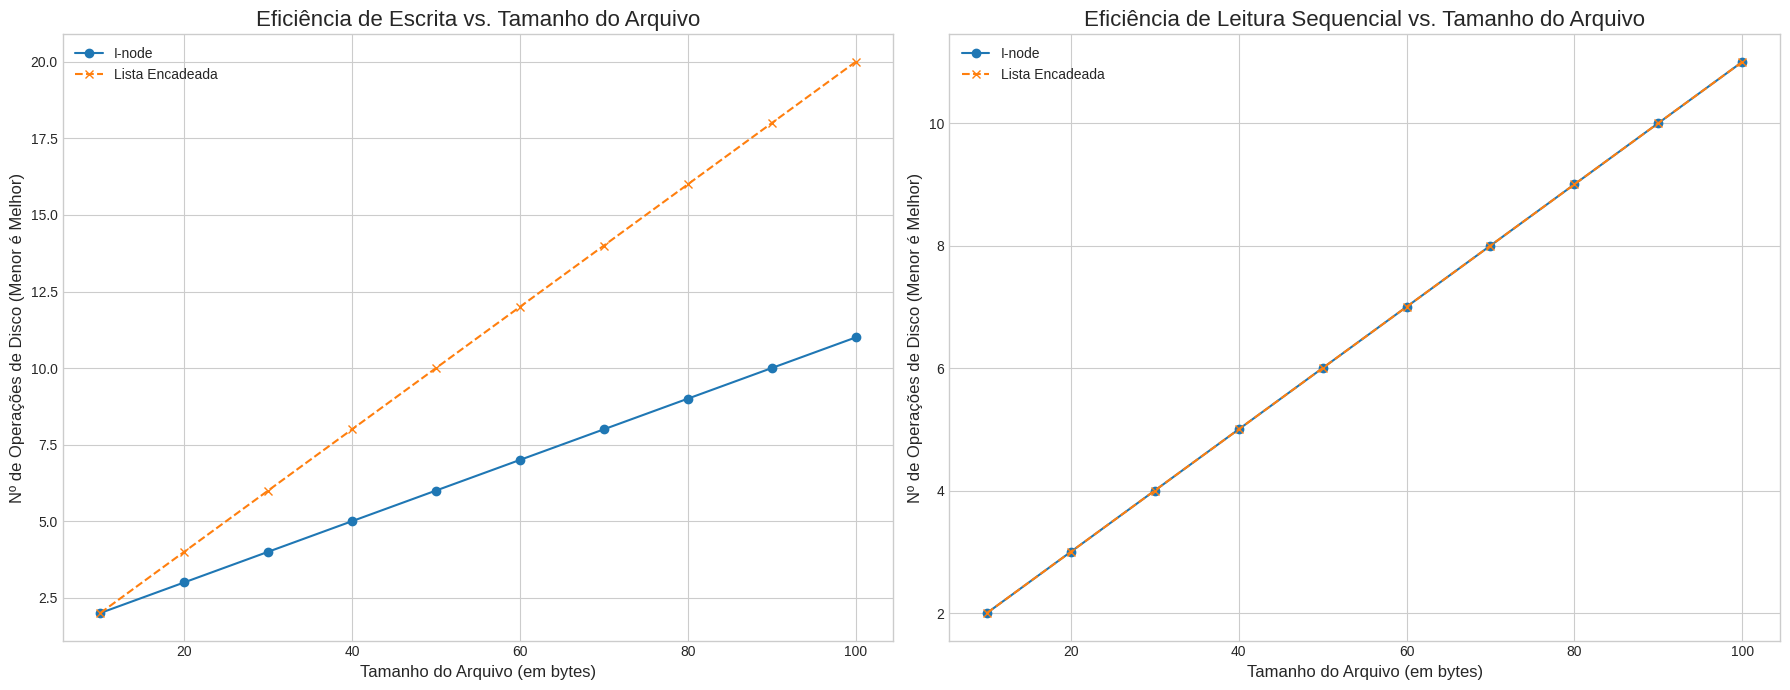

Arquivo de script 'comandos.txt' criado com sucesso.
Executando comandos do script: 'comandos.txt'

# --- INÍCIO DO TESTE: SISTEMA I-NODE ---
[inode] $ mkdir teste_dir
Diretório 'teste_dir' criado.
[inode] $ cd teste_dir
[inode] $ touch arquivo.txt
Arquivo 'arquivo.txt' criado.
[inode] $ write arquivo.txt
78 bytes escritos em 'arquivo.txt'.
[inode] $ stat arquivo.txt
--- Estatísticas para 'arquivo.txt' (I-node) ---
  I-node ID: 2, Tamanho: 78 bytes
  Alocação: Acesso Direto via I-node
  Ponteiros para Blocos: [2, 3, 4, 5, 6, 7, 8, 9]
[inode] $ read arquivo.txt
--- Conteúdo de arquivo.txt ---
Linha 1 do arquivo de teste.
Linha 2 para ocupar mais blocos.
Linha 3 e final.
--- Fim do Arquivo ---
[inode] $ df
Uso do Disco (I-node):
  I-nodes: 3/20
  Blocos : 10/100
[inode] $ cd ..
[inode] $ ls
d	0B	2025-07-11 17:50	.
d	0B	2025-07-11 17:50	..
d	0B	2025-07-11 17:50	teste_dir

# --- TROCA DE SISTEMA ---
[inode] $ switch
--> Sistema alterado para: lista

# --- INÍCIO DO TESTE: SISTEMA LISTA ENC

/tmp/ipython-input-20-3149031671.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sistema de Arquivos', y='Total de Operações', data=total_ops, ax=ax, palette=['#4C72B0', '#DD8452'])


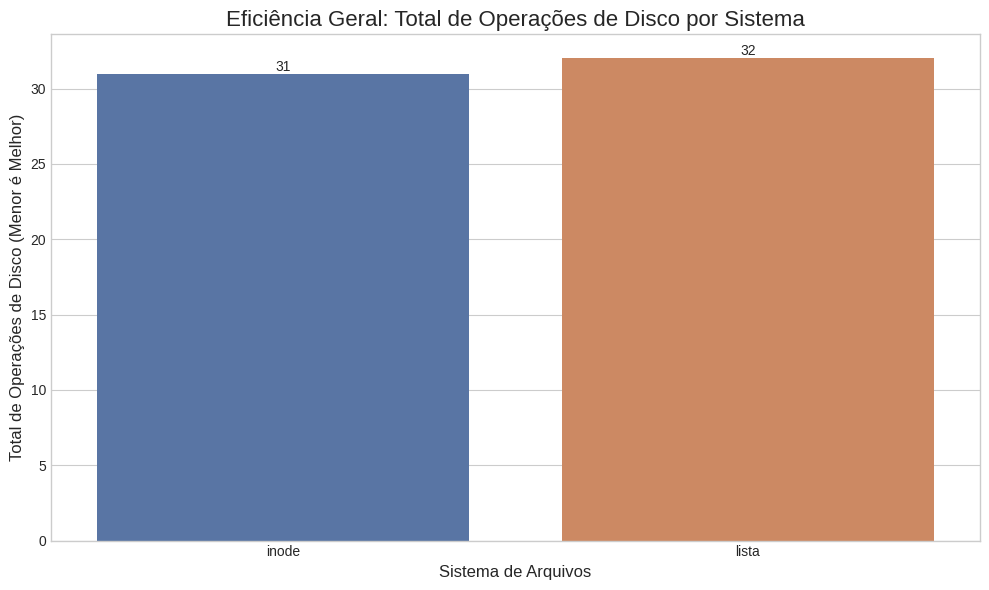


----------------------------------------
--- Uso Final de Recursos (no momento do 'exit') ---
Sistema de Arquivos  Blocos de Dados Finais  I-nodes Finais
              inode                      10               3
              lista                       8               0

* Mostra o custo de armazenamento de metadados.


/tmp/ipython-input-20-3149031671.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sistema de Arquivos', y='Blocos de Dados Finais', data=final_usage_table, ax=ax, palette=['#55A868', '#C44E52'])


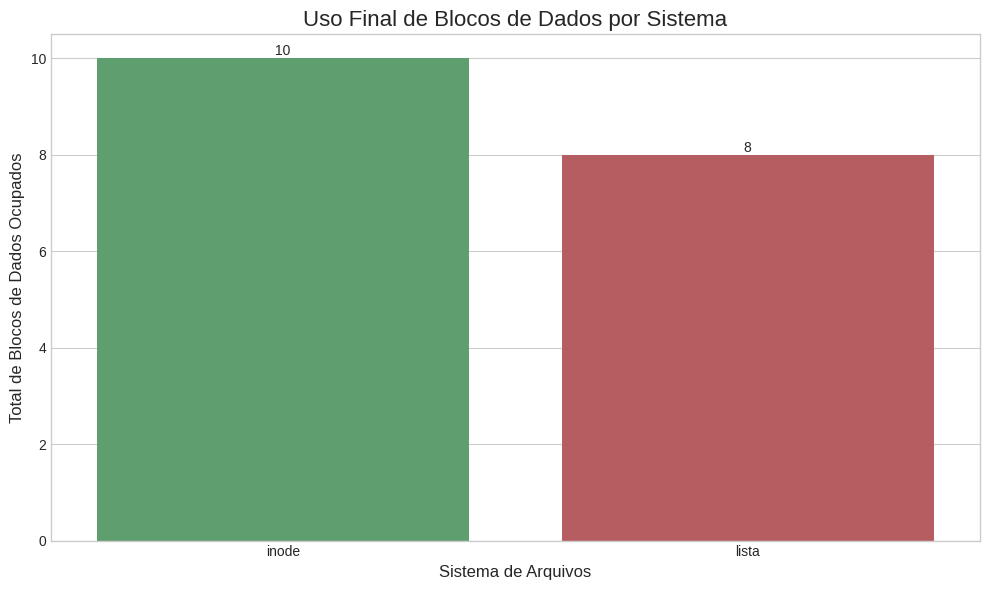

In [ ]:
def executar_teste_desempenho():
    """Executa um teste de escrita e leitura para vários tamanhos de arquivo."""
    print("\n" + "="*60)
    print("INICIANDO TESTE DE DESEMPENHO AUTOMATIZADO")
    print("="*60)
    tamanhos_teste = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    resultados = []
    for tamanho in tamanhos_teste:
        conteudo = "x" * tamanho
        fs_inode = SistemaArquivosInode()
        fs_inode.touch("teste.txt")
        ops_escrita_inode = fs_inode.write("teste.txt", conteudo, verbose=False)
        ops_leitura_inode = fs_inode.read("teste.txt", verbose=False)
        fs_lista = SistemaArquivosListaEncadeada()
        fs_lista.touch("teste.txt")
        ops_escrita_lista = fs_lista.write("teste.txt", conteudo, verbose=False)
        ops_leitura_lista = fs_lista.read("teste.txt", verbose=False)
        resultados.append({
            "tamanho_arquivo": tamanho,
            "escrita_inode": ops_escrita_inode, "leitura_inode": ops_leitura_inode,
            "escrita_lista": ops_escrita_lista, "leitura_lista": ops_leitura_lista
        })
    print("Teste de desempenho concluído.")
    return pd.DataFrame(resultados)

def gerar_graficos_desempenho(df_resultados):
    """Gera gráficos de linha comparando a eficiência de escrita e leitura."""
    print("\n" + "="*60)
    print("GRÁFICOS DE DESEMPENHO: LEITURA E ESCRITA")
    print("="*60)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    # Gráfico 1: Eficiência de Escrita
    axes[0].plot(df_resultados['tamanho_arquivo'], df_resultados['escrita_inode'], marker='o', label='I-node')
    axes[0].plot(df_resultados['tamanho_arquivo'], df_resultados['escrita_lista'], marker='x', linestyle='--', label='Lista Encadeada')
    axes[0].set_title('Eficiência de Escrita vs. Tamanho do Arquivo', fontsize=16)
    axes[0].set_xlabel('Tamanho do Arquivo (em bytes)', fontsize=12)
    axes[0].set_ylabel('Nº de Operações de Disco (Menor é Melhor)', fontsize=12)
    axes[0].legend()
    # Gráfico 2: Eficiência de Leitura
    axes[1].plot(df_resultados['tamanho_arquivo'], df_resultados['leitura_inode'], marker='o', label='I-node')
    axes[1].plot(df_resultados['tamanho_arquivo'], df_resultados['leitura_lista'], marker='x', linestyle='--', label='Lista Encadeada')
    axes[1].set_title('Eficiência de Leitura Sequencial vs. Tamanho do Arquivo', fontsize=16)
    axes[1].set_xlabel('Tamanho do Arquivo (em bytes)', fontsize=12)
    axes[1].set_ylabel('Nº de Operações de Disco (Menor é Melhor)', fontsize=12)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

def generate_final_report(history):
    if not history: print("Nenhum comando executado."); return
    print("\n" + "="*60)
    print("RELATÓRIO FINAL DE EFICIÊNCIA E USO DE DISCO")
    print("="*60)

    df = pd.DataFrame(history)

    # Tabela de Eficiência Total
    total_ops = df.groupby('sistema')['operacoes'].sum().reset_index()
    total_ops.columns = ['Sistema de Arquivos', 'Total de Operações']

    print("--- Eficiência Geral (Total de Operações) ---")
    print(total_ops.to_string(index=False))
    print("\n* Menor é melhor.")

    # Gráfico de Barras para Eficiência Total
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Sistema de Arquivos', y='Total de Operações', data=total_ops, ax=ax, palette=['#4C72B0', '#DD8452'])
    ax.set_title('Eficiência Geral: Total de Operações de Disco por Sistema', fontsize=16)
    ax.set_xlabel('Sistema de Arquivos', fontsize=12)
    ax.set_ylabel('Total de Operações de Disco (Menor é Melhor)', fontsize=12)
    for container in ax.containers: ax.bar_label(container, fmt='%d')
    plt.tight_layout(); plt.show()

    # Tabela e Gráfico para Uso Final de Blocos
    print("\n" + "-"*40)
    print("--- Uso Final de Recursos (no momento do 'exit') ---")
    final_usage = df.loc[df.groupby('sistema')['comando_n'].idxmax()]
    final_usage_table = final_usage[['sistema', 'blocos_usados', 'inodes_usados']].rename(columns={
        'sistema': 'Sistema de Arquivos',
        'blocos_usados': 'Blocos de Dados Finais',
        'inodes_usados': 'I-nodes Finais'
    }).fillna(0).astype({'I-nodes Finais': int})
    print(final_usage_table.to_string(index=False))
    print("\n* Mostra o custo de armazenamento de metadados.")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Sistema de Arquivos', y='Blocos de Dados Finais', data=final_usage_table, ax=ax, palette=['#55A868', '#C44E52'])
    ax.set_title('Uso Final de Blocos de Dados por Sistema', fontsize=16)
    ax.set_xlabel('Sistema de Arquivos', fontsize=12)
    ax.set_ylabel('Total de Blocos de Dados Ocupados', fontsize=12)
    for container in ax.containers: ax.bar_label(container, fmt='%d')
    plt.tight_layout(); plt.show()

def criar_script_de_teste(nome_arquivo="comandos.txt"):
    #comparação justa.
    bloco_teste = [
        "mkdir teste_dir",
        "cd teste_dir",
        "touch arquivo.txt",
        "write arquivo.txt",
        "---BEGIN-WRITE---",
        "Linha 1 do arquivo de teste.",
        "Linha 2 para ocupar mais blocos.",
        "Linha 3 e final.",
        "---END-WRITE---",
        "stat arquivo.txt",
        "read arquivo.txt",
        "df",
        "cd ..",
        "ls"
    ]
    """
    # foco em escrita
    bloco_teste = [
        "mkdir relatorios_vendas",
        "cd relatorios_vendas",
        "touch vendas_jan.csv",
        "touch vendas_fev.csv",
        "touch vendas_mar.csv",
        "write vendas_jan.csv",
        "---BEGIN-WRITE---",
        "ID,Valor\n1,150\n2,200",
        "---END-WRITE---",
        "write vendas_fev.csv",
        "---BEGIN-WRITE---",
        "ID,Valor\n3,300\n4,50",
        "---END-WRITE---",
        "write vendas_mar.csv",
        "---BEGIN-WRITE---",
        "ID,Valor\n5,500\n6,120\n7,30",
        "---END-WRITE---",
        "ls",
        "df"
    ]
    # foco em leitura
    bloco_teste = [
        "mkdir logs",
        "cd logs",
        "touch log_servidor.txt",
        "write log_servidor.txt",
        "---BEGIN-WRITE---",
        "[INFO] Servidor iniciado com sucesso.",
        "[WARN] Conexao instavel detectada.",
        "[INFO] Usuario 'admin' autenticado.",
        "[ERROR] Falha ao aceder ao recurso X.",
        "[INFO] Backup concluido.",
        "---END-WRITE---",
        "read log_servidor.txt",
        "read log_servidor.txt",
        "read log_servidor.txt",
        "read log_servidor.txt",
        "read log_servidor.txt",
        "stat log_servidor.txt",
        "df"
    ]
    """
    comandos = [
        "# --- INÍCIO DO TESTE: SISTEMA I-NODE ---",
        *bloco_teste,
        "# --- TROCA DE SISTEMA ---",
        "switch",
        "# --- INÍCIO DO TESTE: SISTEMA LISTA ENCADEADA ---",
        *bloco_teste,
        "# --- FIM DA SIMULAÇÃO ---",
        "exit"
    ]
    with open(nome_arquivo, 'w') as f: f.write("\n".join(comandos))
    print(f"Arquivo de script '{nome_arquivo}' criado com sucesso.")

def main(script_path=None):
    sistemas = {'inode': SistemaArquivosInode(), 'lista': SistemaArquivosListaEncadeada()}
    sistema_atual = 'inode'
    history, command_count, comandos_a_executar = [], 0, []
    if script_path:
        print(f"Executando comandos do script: '{script_path}'\n" + "="*50)
        with open(script_path, 'r') as f: comandos_a_executar = f.read().splitlines()
    else:
        print("="*50 + "\nSimulador de Sistema de Arquivos v5.3 (Final Corrigido)\n" + f"Sistema atual: {sistema_atual}\n" + "="*50)
    idx_comando = 0
    while True:
        try:
            if comandos_a_executar:
                if idx_comando >= len(comandos_a_executar): break
                comando_str = comandos_a_executar[idx_comando]; idx_comando += 1
                if comando_str.startswith('#'): print(f"\n{comando_str}"); continue
                print(f"[{sistema_atual}] $ {comando_str}")
            else:
                comando_str = input(f"[{sistema_atual}] / $ ")
            partes = comando_str.split()
            if not partes: continue
            cmd, args = partes[0], partes[1:]
            if cmd == "exit": break
            fs, ops = sistemas[sistema_atual], 0
            if cmd == "switch": sistema_atual = 'lista' if sistema_atual == 'inode' else 'inode'; print(f"--> Sistema alterado para: {sistema_atual}")
            elif cmd == "write" and len(args) == 1:
                conteudo_linhas = []
                if comandos_a_executar and idx_comando < len(comandos_a_executar) and comandos_a_executar[idx_comando] == "---BEGIN-WRITE---":
                    idx_comando += 1
                    while idx_comando < len(comandos_a_executar) and comandos_a_executar[idx_comando] != "---END-WRITE---":
                        conteudo_linhas.append(comandos_a_executar[idx_comando]); idx_comando += 1
                    if idx_comando < len(comandos_a_executar): idx_comando += 1
                ops = fs.write(args[0], "\n".join(conteudo_linhas))
            elif cmd == "df" and not args: ops = fs.df()
            elif cmd == "rm" and len(args) == 1 and isinstance(fs, SistemaArquivosInode): ops = fs.rm(args[0])
            elif cmd == "ls" and not args: ops = fs.ls()
            elif cmd == "cd" and len(args) == 1: ops = fs.cd(args[0])
            elif cmd == "mkdir" and len(args) == 1: ops = fs.mkdir(args[0])
            elif cmd == "touch" and len(args) == 1: ops = fs.touch(args[0])
            elif cmd == "stat" and len(args) == 1: ops = fs.stat(args[0])
            elif cmd == "read" and len(args) == 1: ops = fs.read(args[0])
            elif cmd == "mv" and len(args) == 2 and isinstance(fs, SistemaArquivosInode): ops = fs.mv(args[0], args[1])
            else: print(f"Comando inválido: '{comando_str}'")
            if ops >= 0:
                command_count += 1
                inodes_usados, blocos_usados = fs.get_disk_usage()
                history.append({'comando_n': command_count, 'comando_completo': comando_str, 'sistema': sistema_atual, 'operacoes': ops, 'inodes_usados': inodes_usados, 'blocos_usados': blocos_usados})
        except Exception as e: print(f"Ocorreu um erro: {e}", file=sys.stderr)
    generate_final_report(history)

if __name__ == "__main__":
    # 1. Executa o teste de desempenho automatizado
    resultados_teste = executar_teste_desempenho()
    gerar_graficos_desempenho(resultados_teste)

    # 2. Executa o roteiro de comandos para demonstração e relatório final
    criar_script_de_teste("comandos.txt")
    main("comandos.txt")